# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
#install scipy
!pip install scipy==1.1.0

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
#install Pillow
!pip install Pillow==5.3. 0

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
#install keras
!pip install keras

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

##### We set the random seed so that the results don't vary drastically.

In this block under Generator, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [6]:
project_folder='/home/datasets/Project_data'

**data path: /home/datasets/Project_data**

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                               
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
class Conv3DModel(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3D1=Conv3DModel()
conv_3D1.initialize_path(project_folder)
conv_3D1.initialize_image_properties(image_height=160,image_width=160)
conv_3D1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3D1_model=conv_3D1.define_model()
print("Total Params:", conv_3D1_model.count_params())
conv_3D1.train_model(conv_3D1_model)

Total Params: 1736389
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4544 - categorical_accuracy: 0.4540
Epoch 00001: saving model to model_init_2021-08-0813_26_18.877191/model-00001-1.45443-0.45400-7.71667-0.21000.h5
45/45 [==============================] - 96s 2s/step - loss: 1.4544 - categorical_accuracy: 0.4540 - val_loss: 7.7167 - val_categorical_accuracy: 0.2100
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9943 - categorical_accuracy: 0.6124
Epoch 00002: saving model to model_init_2021-08-0813_26_18.877191/model-00002-0.99425-0.61237-13.30983-0.20000.h5
45/45 [==============================] - 97s 2s/step - loss: 0.9943 - categorical_accuracy: 0.6124 - val_loss: 13.3098 - val_categorical_accuracy: 0.2000


In [12]:
conv_3D1=Conv3DModel()
conv_3D1.initialize_path(project_folder)
conv_3D1.initialize_image_properties(image_height=100,image_width=100)
conv_3D1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3D1_model=conv_3D1.define_model()
print("Total Params:", conv_3D1_model.count_params())
conv_3D1.train_model(conv_3D1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.4324 - categorical_accuracy: 0.4585
Epoch 00001: saving model to model_init_2021-08-0813_29_39.101933/model-00001-1.43238-0.45852-1.70762-0.21000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.4324 - categorical_accuracy: 0.4585 - val_loss: 1.7076 - val_categorical_accuracy: 0.2100
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 0.8135 - categorical_accuracy: 0.6863
Epoch 00002: saving model to model_init_2021-08-0813_29_39.101933/model-00002-0.81354-0.68627-1.93946-0.17000.h5
34/34 [==============================] - 82s 2s/step - loss: 0.8135 - categorical_accuracy: 0.6863 - val_loss: 1.9395 - val_categorical_accuracy: 0.1700


In [13]:
conv_3D1=Conv3DModel()
conv_3D1.initialize_path(project_folder)
conv_3D1.initialize_image_properties(image_height=160,image_width=160)
conv_3D1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3D1_model=conv_3D1.define_model()
print("Total Params:", conv_3D1_model.count_params())
conv_3D1.train_model(conv_3D1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.4110 - categorical_accuracy: 0.4525
Epoch 00001: saving model to model_init_2021-08-0813_32_27.386630/model-00001-1.41103-0.45249-1.98256-0.16000.h5
23/23 [==============================] - 51s 2s/step - loss: 1.4110 - categorical_accuracy: 0.4525 - val_loss: 1.9826 - val_categorical_accuracy: 0.1600
Epoch 2/2
22/23 [===========================>..] - ETA: 1s - loss: 0.8414 - categorical_accuracy: 0.6803
Epoch 00002: saving model to model_init_2021-08-0813_32_27.386630/model-00002-0.85076-0.67873-4.50714-0.18000.h5
23/23 [==============================] - 52s 2s/step - loss: 0.8508 - categorical_accuracy: 0.6787 - val_loss: 4.5071 - val_categorical_accuracy: 0.1800


In [14]:
conv_3D1=Conv3DModel()
conv_3D1.initialize_path(project_folder)
conv_3D1.initialize_image_properties(image_height=160,image_width=160)
conv_3D1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3D1_model=conv_3D1.define_model()
print("Total Params:", conv_3D1_model.count_params())
conv_3D1.train_model(conv_3D1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.4951 - categorical_accuracy: 0.4495
Epoch 00001: saving model to model_init_2021-08-0813_34_14.606007/model-00001-1.49508-0.44947-2.98979-0.16000.h5
17/17 [==============================] - 52s 3s/step - loss: 1.4951 - categorical_accuracy: 0.4495 - val_loss: 2.9898 - val_categorical_accuracy: 0.1600
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.8697 - categorical_accuracy: 0.6667
Epoch 00002: saving model to model_init_2021-08-0813_34_14.606007/model-00002-0.86972-0.66667-9.41237-0.11000.h5
17/17 [==============================] - 51s 3s/step - loss: 0.8697 - categorical_accuracy: 0.6667 - val_loss: 9.4124 - val_categorical_accuracy: 0.1100


# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 2

In [15]:
class Conv3DModel(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3D1=Conv3DModel()
conv_3D1.initialize_path(project_folder)
conv_3D1.initialize_image_properties(image_height=160,image_width=160)
conv_3D1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3D1_model=conv_3D1.define_model()
conv_3D1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 80, 80, 32)   

In [17]:
print("Total Params:", conv_3D1_model.count_params())
history_model1 = conv_3D1.train_model(conv_3D1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.4737 - categorical_accuracy: 0.4495
Epoch 00001: saving model to model_init_2021-08-0813_36_56.581361/model-00001-1.47369-0.44947-1.49996-0.36000.h5
17/17 [==============================] - 64s 4s/step - loss: 1.4737 - categorical_accuracy: 0.4495 - val_loss: 1.5000 - val_categorical_accuracy: 0.3600
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.7718 - categorical_accuracy: 0.6953
Epoch 00002: saving model to model_init_2021-08-0813_36_56.581361/model-00002-0.77178-0.69532-2.68613-0.18000.h5
17/17 [==============================] - 65s 4s/step - loss: 0.7718 - categorical_accuracy: 0.6953 - val_loss: 2.6861 - val_categorical_accuracy: 0.1800
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.5291 - categorical_accuracy: 0.8250
Epoch 00003: saving model to model_init_2021-08-0813_36_56.581361/model-00003-0.52913-0.82504-4.11957-0.20000.h5
17/17 [========

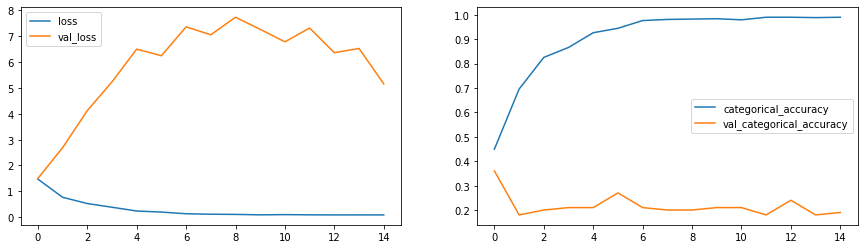

In [18]:
plot(history_model1)

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [19]:
conv_3D2=Conv3DModel()
conv_3D2.initialize_path(project_folder)
conv_3D2.initialize_image_properties(image_height=160,image_width=160)
conv_3D2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3D2_model=conv_3D2.define_model()
conv_3D2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_21 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 10, 80, 80, 32)   

In [20]:
print("Total Params:", conv_3D2_model.count_params())
history_model2 = conv_3D2.train_model(conv_3D2_model)

Total Params: 1117061
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6283 - categorical_accuracy: 0.3922
Epoch 00001: saving model to model_init_2021-08-0813_55_24.669126/model-00001-1.62829-0.39216-2.19610-0.16000.h5
34/34 [==============================] - 65s 2s/step - loss: 1.6283 - categorical_accuracy: 0.3922 - val_loss: 2.1961 - val_categorical_accuracy: 0.1600
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.0203 - categorical_accuracy: 0.6167
Epoch 00002: saving model to model_init_2021-08-0813_55_24.669126/model-00002-1.02054-0.61538-3.40010-0.24000.h5
34/34 [==============================] - 70s 2s/step - loss: 1.0205 - categorical_accuracy: 0.6154 - val_loss: 3.4001 - val_categorical_accuracy: 0.2400
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 0.7753 - categorical_accuracy: 0.7091
Epoch 00003: saving model to model_init_2021-08-0813_55_24.669126/model-00003-0.77392-0.70890-3.31278-0.23000.h5
34/34 [========

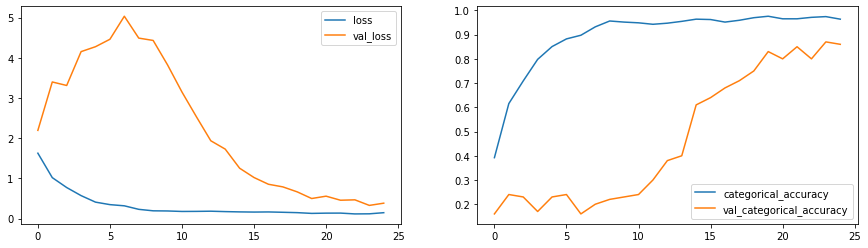

In [21]:
plot(history_model2)

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [22]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_24 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_25 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 60, 60, 32)    

In [24]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1209 - categorical_accuracy: 0.3401
Epoch 00001: saving model to model_init_2021-08-0814_25_37.105339/model-00001-2.12088-0.34012-1.76085-0.16000.h5
23/23 [==============================] - 89s 4s/step - loss: 2.1209 - categorical_accuracy: 0.3401 - val_loss: 1.7608 - val_categorical_accuracy: 0.1600
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4292 - categorical_accuracy: 0.4849
Epoch 00002: saving model to model_init_2021-08-0814_25_37.105339/model-00002-1.42924-0.48492-2.78195-0.18000.h5
23/23 [==============================] - 86s 4s/step - loss: 1.4292 - categorical_accuracy: 0.4849 - val_loss: 2.7819 - val_categorical_accuracy: 0.1800
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2020 - categorical_accuracy: 0.5732
Epoch 00003: saving model to model_init_2021-08-0814_25_37.105339/model-00003-1.20202-0.57315-4.23763-0.18000.h5
23/23 [========

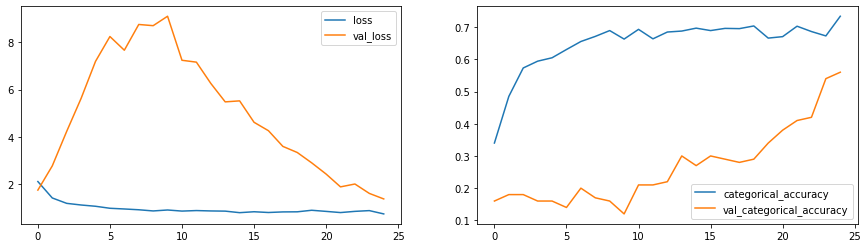

In [25]:
plot(history_model3)

##### Model has a best validation accuracy of 74% and training accuracy of 56% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [26]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_29 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 8, 60, 60, 16)    

In [28]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0133 - categorical_accuracy: 0.3725
Epoch 00001: saving model to model_init_2021-08-0815_03_18.607744/model-00001-2.01330-0.37255-2.20412-0.23000.h5
34/34 [==============================] - 84s 2s/step - loss: 2.0133 - categorical_accuracy: 0.3725 - val_loss: 2.2041 - val_categorical_accuracy: 0.2300
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4457 - categorical_accuracy: 0.5090
Epoch 00002: saving model to model_init_2021-08-0815_03_18.607744/model-00002-1.44566-0.50905-2.43364-0.16000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.4457 - categorical_accuracy: 0.5090 - val_loss: 2.4336 - val_categorical_accuracy: 0.1600
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1566 - categorical_accuracy: 0.5860
Epoch 00003: saving model to model_init_2021-08-0815_03_18.607744/model-00003-1.15662-0.58597-2.47899-0.23000.h5
34/34 [========

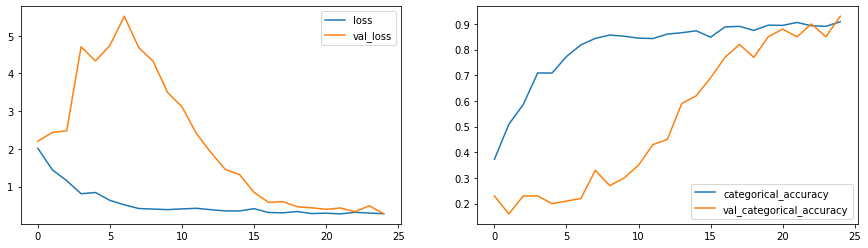

In [29]:
plot(history_model4)

##### With more layers we  see performance improvement. We get a best validation accuracy of 93% . Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [30]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 60, 60, 16)    

In [32]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7847 - categorical_accuracy: 0.3703
Epoch 00001: saving model to model_init_2021-08-0815_47_54.581643/model-00001-1.78470-0.37029-1.94204-0.21000.h5
34/34 [==============================] - 95s 3s/step - loss: 1.7847 - categorical_accuracy: 0.3703 - val_loss: 1.9420 - val_categorical_accuracy: 0.2100
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3244 - categorical_accuracy: 0.4977
Epoch 00002: saving model to model_init_2021-08-0815_47_54.581643/model-00002-1.32436-0.49774-2.13309-0.23000.h5
34/34 [==============================] - 93s 3s/step - loss: 1.3244 - categorical_accuracy: 0.4977 - val_loss: 2.1331 - val_categorical_accuracy: 0.2300
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.2308 - categorical_accuracy: 0.5475
Epoch 00003: saving model to model_init_2021-08-0815_47_54.581643/model-00003-1.23078-0.54751-2.13785-0.35000.h5
34/34 [========

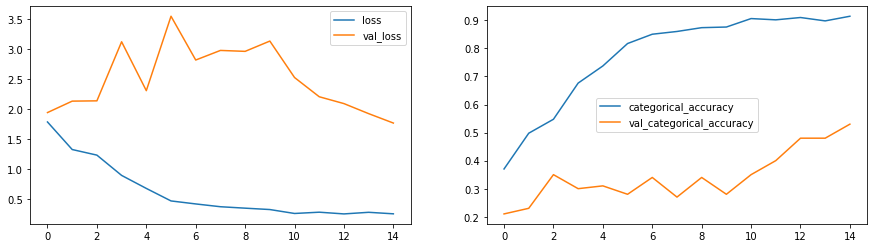

In [33]:
plot(history_model5)

###### it is Overfitting, Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [34]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_44 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_45 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 8, 50, 50, 32)    

In [36]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7232 - categorical_accuracy: 0.3854
Epoch 00001: saving model to model_init_2021-08-0816_12_28.887867/model-00001-1.72320-0.38537-2.10401-0.16000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.7232 - categorical_accuracy: 0.3854 - val_loss: 2.1040 - val_categorical_accuracy: 0.1600
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0920 - categorical_accuracy: 0.5709
Epoch 00002: saving model to model_init_2021-08-0816_12_28.887867/model-00002-1.09204-0.57089-2.90874-0.17000.h5
34/34 [==============================] - 78s 2s/step - loss: 1.0920 - categorical_accuracy: 0.5709 - val_loss: 2.9087 - val_categorical_accuracy: 0.1700
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8611 - categorical_accuracy: 0.6750
Epoch 00003: saving model to model_init_2021-08-0816_12_28.887867/model-00003-0.86114-0.67496-3.48384-0.18000.h5
34/34 [=========

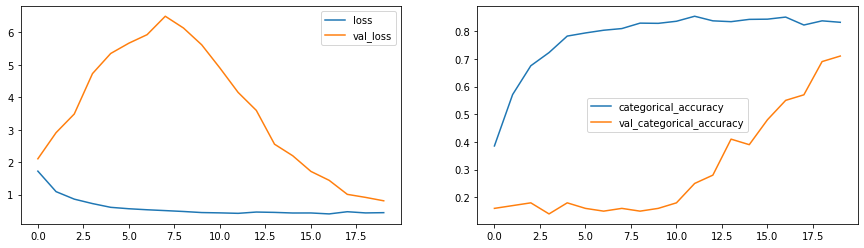

In [37]:
plot(history_model6)

###### For the above low memory foot print model, we get the best validation accuracy of 71%

## Model 7 - Reducing the number of parameters again

In [13]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     1

In [15]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8370 - categorical_accuracy: 0.3477
Epoch 00001: saving model to model_init_2021-08-0817_52_06.691768/model-00001-1.83695-0.34766-1.72210-0.21000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.8370 - categorical_accuracy: 0.3477 - val_loss: 1.7221 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1776 - categorical_accuracy: 0.5377
Epoch 00002: saving model to model_init_2021-08-0817_52_06.691768/model-00002-1.17762-0.53771-2.10195-0.21000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.1776 - categorical_accuracy: 0.5377 - val_loss: 2.1019 - val_categorical_accuracy: 0.2100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9310 - categorical_accuracy: 0.6365
Epoch 00003: saving model to model_init_2021-08-0817_

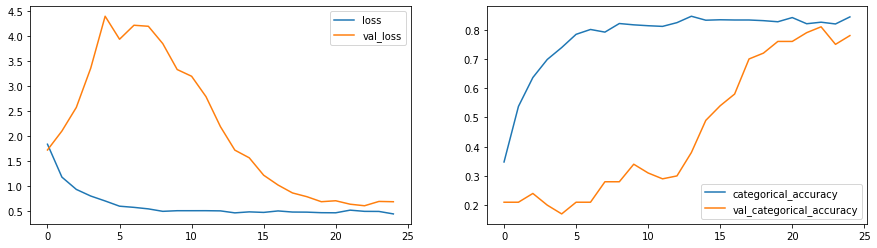

In [16]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 78%

## Model 8 - CNN- LSTM Model

In [10]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)    1

In [19]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4361 - categorical_accuracy: 0.3778
Epoch 00001: saving model to model_init_2021-08-0904_11_29.172471/model-00001-1.43611-0.37783-1.71723-0.18000.h5
34/34 [==============================] - 100s 3s/step - loss: 1.4361 - categorical_accuracy: 0.3778 - val_loss: 1.7172 - val_categorical_accuracy: 0.1800
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1808 - categorical_accuracy: 0.5279
Epoch 00002: saving model to model_init_2021-08-0904_11_29.172471/model-00002-1.18081-0.52790-2.60433-0.15000.h5
34/34 [==============================] - 99s 3s/step - loss: 1.1808 - categorical_accuracy: 0.5279 - val_loss: 2.6043 - val_categorical_accuracy: 0.1500
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9315 - categorical_accuracy: 0.6523
Epoch 00003: saving model to model_init_2021-08-090

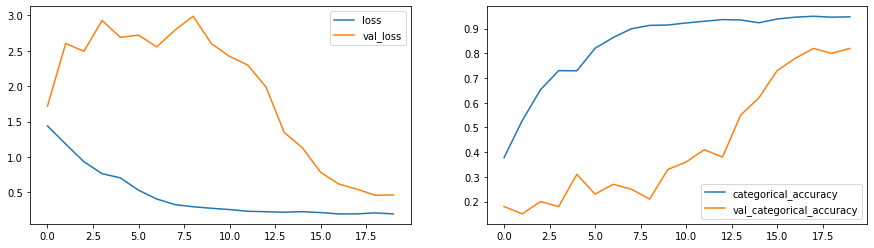

In [26]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 82%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [12]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

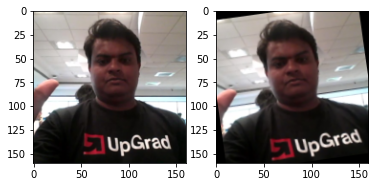

In [13]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [14]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 80, 80, 32)   

In [31]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.9740 - categorical_accuracy: 0.3635
Epoch 00001: saving model to model_init_2021-08-0904_46_40.213171/model-00001-1.97404-0.36350-2.56464-0.21000.h5
34/34 [==============================] - 128s 4s/step - loss: 1.9740 - categorical_accuracy: 0.3635 - val_loss: 2.5646 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4022 - categorical_accuracy: 0.5294
Epoch 00002: saving model to model_init_2021-08-0904_46_40.213171/model-00002-1.40224-0.52941-4.11776-0.22000.h5
34/34 [==============================] - 129s 4s/step - loss: 1.4022 - categorical_accuracy: 0.5294 - val_loss: 4.1178 - val_categorical_accuracy: 0.2200
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1681 - categorical_accuracy: 0.5867
Epoch 00003: saving model to model_init_2021-08-0904_46_40.213171/model-00003-1.16812-0.58673-5.43880-0.22000.h5
34/34 [======

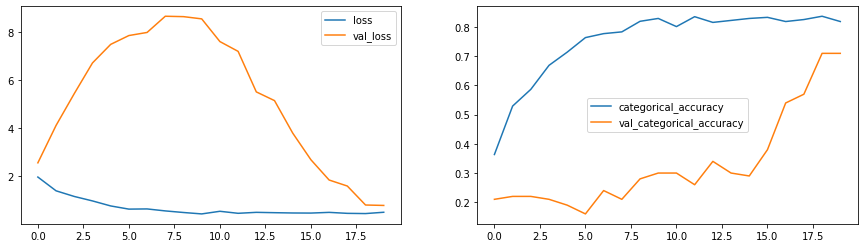

In [32]:
plot(history_model9)

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [33]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 60, 60, 32)    

In [35]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.2290 - categorical_accuracy: 0.3077
Epoch 00001: saving model to model_init_2021-08-0905_30_23.493796/model-00001-2.22896-0.30769-1.88226-0.21000.h5
23/23 [==============================] - 87s 4s/step - loss: 2.2290 - categorical_accuracy: 0.3077 - val_loss: 1.8823 - val_categorical_accuracy: 0.2100
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4554 - categorical_accuracy: 0.5000
Epoch 00002: saving model to model_init_2021-08-0905_30_23.493796/model-00002-1.45538-0.50000-2.78181-0.19000.h5
23/23 [==============================] - 88s 4s/step - loss: 1.4554 - categorical_accuracy: 0.5000 - val_loss: 2.7818 - val_categorical_accuracy: 0.1900
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.1643 - categorical_accuracy: 0.5995
Epoch 00003: saving model to model_init_2021-08-0905_30_23.493796/model-00003-1.16430-0.59955-3.43486-0.21000.h5
23/23 [========

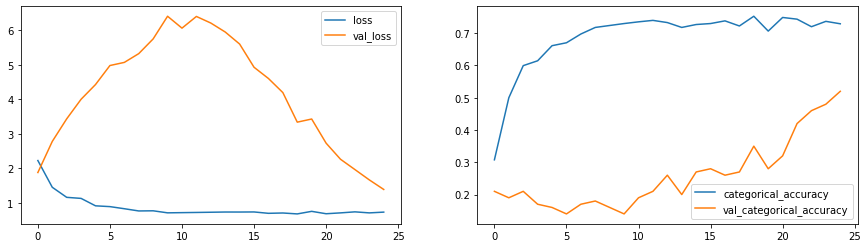

In [36]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [37]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [38]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)    

In [39]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1373 - categorical_accuracy: 0.3326
Epoch 00001: saving model to model_init_2021-08-0906_12_08.989807/model-00001-2.13732-0.33258-1.94868-0.21000.h5
34/34 [==============================] - 88s 3s/step - loss: 2.1373 - categorical_accuracy: 0.3326 - val_loss: 1.9487 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5043 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2021-08-0906_12_08.989807/model-00002-1.50431-0.50528-2.93824-0.22000.h5
34/34 [==============================] - 89s 3s/step - loss: 1.5043 - categorical_accuracy: 0.5053 - val_loss: 2.9382 - val_categorical_accuracy: 0.2200
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3299 - categorical_accuracy: 0.5498
Epoch 00003: saving model to model_init_2021-08-0906_12_08.989807/model-00003-1.32986-0.54977-4.11084-0.23000.h5
34/34 [========

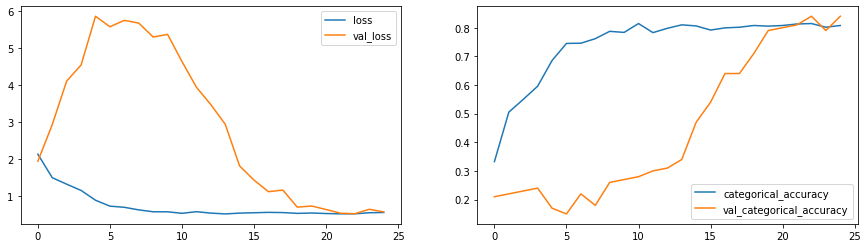

In [40]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [41]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)    

In [43]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9565 - categorical_accuracy: 0.3243
Epoch 00001: saving model to model_init_2021-08-0906_51_40.421741/model-00001-1.95645-0.32428-2.03810-0.21000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.9565 - categorical_accuracy: 0.3243 - val_loss: 2.0381 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5568 - categorical_accuracy: 0.4329
Epoch 00002: saving model to model_init_2021-08-0906_51_40.421741/model-00002-1.55681-0.43288-2.96414-0.14000.h5
34/34 [==============================] - 89s 3s/step - loss: 1.5568 - categorical_accuracy: 0.4329 - val_loss: 2.9641 - val_categorical_accuracy: 0.1400
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3647 - categorical_accuracy: 0.5023
Epoch 00003: saving model to model_init_2021-08-0906_51_40.421741/model-00003-1.36475-0.50226-3.96174-0.21000.h5
34/34 [========

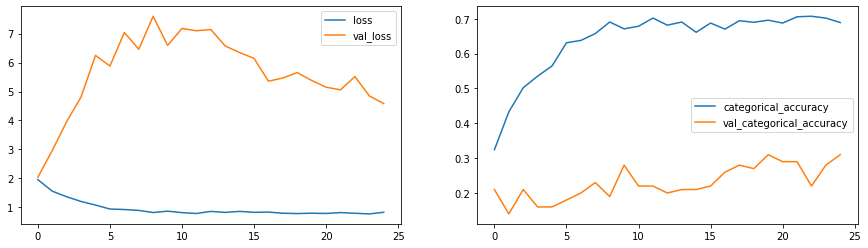

In [44]:
plot(history_model12)

#### Model 12 is overfitting.

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [15]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 50, 50, 32)    

In [17]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8136 - categorical_accuracy: 0.3514
Epoch 00001: saving model to model_init_2021-08-0909_04_35.341799/model-00001-1.81355-0.35143-1.64642-0.21000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.8136 - categorical_accuracy: 0.3514 - val_loss: 1.6464 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1848 - categorical_accuracy: 0.5528
Epoch 00002: saving model to model_init_2021-08-0909_04_35.341799/model-00002-1.18484-0.55279-1.93943-0.20000.h5
34/34 [==============================] - 84s 2s/step - loss: 1.1848 - categorical_accuracy: 0.5528 - val_loss: 1.9394 - val_categorical_accuracy: 0.2000
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9052 - categorical_accuracy: 0.6516
Epoch 00003: saving model to model_init_2021-08-0909_

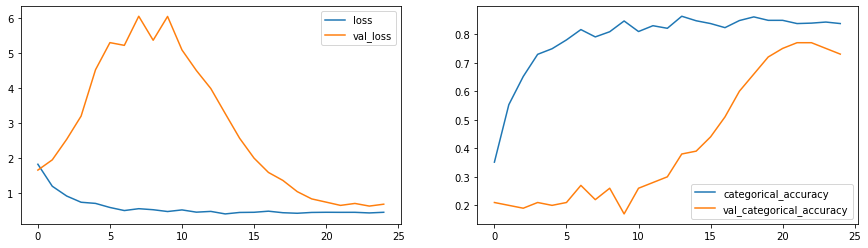

In [18]:
plot(history_model13)

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [19]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 60, 60, 32)    

In [21]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7414 - categorical_accuracy: 0.3356
Epoch 00001: saving model to model_init_2021-08-0909_48_21.579911/model-00001-1.74139-0.33560-1.95239-0.16000.h5
34/34 [==============================] - 84s 2s/step - loss: 1.7414 - categorical_accuracy: 0.3356 - val_loss: 1.9524 - val_categorical_accuracy: 0.1600
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2401 - categorical_accuracy: 0.5181
Epoch 00002: saving model to model_init_2021-08-0909_48_21.579911/model-00002-1.24006-0.51810-2.48260-0.16000.h5
34/34 [==============================] - 84s 2s/step - loss: 1.2401 - categorical_accuracy: 0.5181 - val_loss: 2.4826 - val_categorical_accuracy: 0.1600
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0046 - categorical_accuracy: 0.6116
Epoch 00003: saving model to model_init_2021-08-0909_48_21.579911/model-00003-1.00461-0.61161-2.59586-0.15000.h5
34/34 [=========

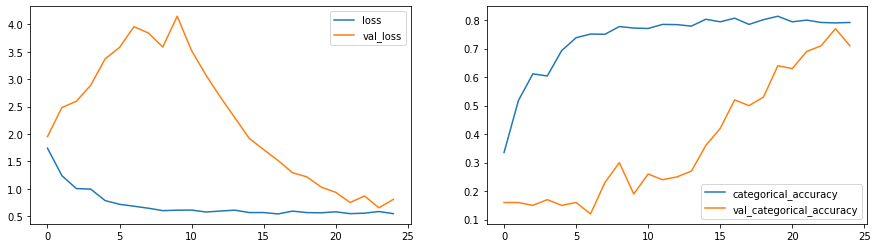

In [22]:
plot(history_model14)

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [23]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 64)   

In [25]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4122 - categorical_accuracy: 0.4231
Epoch 00001: saving model to model_init_2021-08-0910_25_49.203230/model-00001-1.41217-0.42308-1.66172-0.16000.h5
34/34 [==============================] - 94s 3s/step - loss: 1.4122 - categorical_accuracy: 0.4231 - val_loss: 1.6617 - val_categorical_accuracy: 0.1600
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9074 - categorical_accuracy: 0.6697
Epoch 00002: saving model to model_init_2021-08-0910_25_49.203230/model-00002-0.90745-0.66968-2.12365-0.16000.h5
34/34 [==============================] - 94s 3s/step - loss: 0.9074 - categorical_accuracy: 0.6697 - val_loss: 2.1236 - val_categorical_accuracy: 0.1600
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7163 - categorical_accuracy: 0.7330
Epoch 00003: saving model to model_init_2021-08-0910_25_49.203230/model-00003-0.71626-0.73303-2.36078-0.19000.h5
34/34 [========

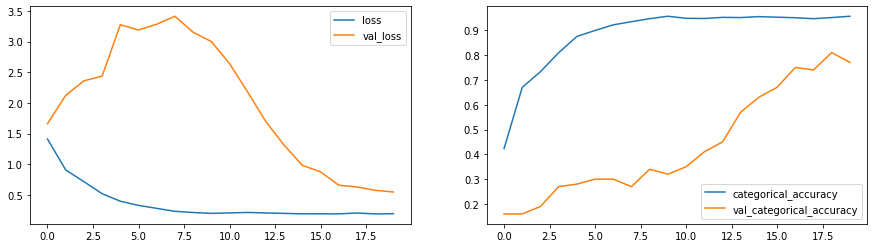

In [26]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

## Model 17 - Transfer Learning with GRU and training all weights

In [27]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [28]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [29]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.9759 - categorical_accuracy: 0.6410
Epoch 00001: saving model to model_init_2021-08-0911_08_10.903965/model-00001-0.97588-0.64103-0.45271-0.83000.h5
133/133 [==============================] - 92s 695ms/step - loss: 0.9759 - categorical_accuracy: 0.6410 - val_loss: 0.4527 - val_categorical_accuracy: 0.8300
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.4239 - categorical_accuracy: 0.8695
Epoch 00002: saving model to model_init_2021-08-0911_08_10.903965/model-00002-0.42390-0.86953-0.32029-0.90000.h5
133/133 [==============================] - 90s 680ms/step - loss: 0.4239 - categorical_accuracy: 0.8695 - val_loss: 0.3203 - val_categorical_accuracy: 0.9000
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2847 - categorical_accuracy: 0.9170
Epoch 00003: saving model to model_init_2021-08-0911_08_10.903965/model-00003-0.28469-0.91704-0.49469-0.86000.h5

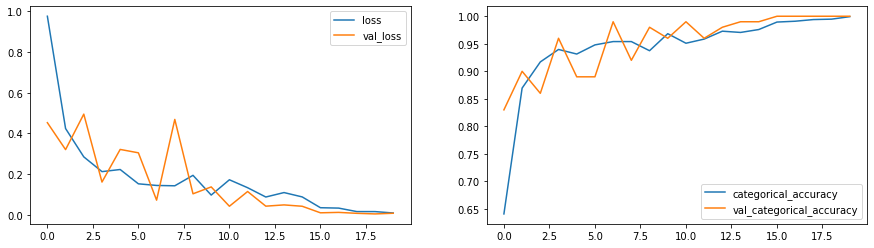

In [30]:
plot(history_model17)

### 99.9992% Training accuracy and an unbelievable 100% validation accuracy :)